## **Parcial Ciencia de Datos Aplicada**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jpcano1/MINE-4101-tareas/blob/master/Parcial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"/>Run in Google Colab</a>
  </td>
</table>

## **Parcial**
- Descripción del caso: La base de datos a utilizar contiene información sobre las exportaciones realizadas en Colombia para el mes de Diciembre de un determinado año. Los datos incluyen el lugar de origen y destino de la exportación, el medio de transporte utilizado, el peso, la cantidad y el valor de la mercancía (incluidos valores de impuestos).  Al final de este enunciado se presenta la descripción detallada de la fuente. Esta fuente de es la base para resolver las preguntas del parcial que se presentan a continuación.

1. **[15%] Entendimiento del negocio y de los datos** 

- A partir de la exploración inicial de los datos: 

    1. [5%] Describa el resultado del perfilamiento de datos e indique el tipo de cada variable.
    2. [10%] Describa el entendimiento que tiene del negocio a partir de los datos suministrados. 


2. **[75%] Análisis y propuestas accionables** 

    3. [15%] Plantee 4 hipótesis de interés para el negocio que al resolverlas generen un beneficio. Justifique su respuesta en términos de los datos, los análisis realizados para definirlas y la organización beneficiaria de la solución. 
    4. [10%] Describa e ilustre los problemas de calidad de los datos que pueden afectar los análisis propuestos en las hipótesis. 
    5. [25%] Realice los ajustes que considere necesarios sobre los datos para realizar los análisis propuestos y justifique sus decisiones.
    6. [25%] Valide 2 de las hipótesis planteadas en el punto anterior. Una de las hipótesis debe ser entre variables numéricas y la otra entre variables categóricas. Indique los sesgos que pueden existir con el análisis realizado para validar las hipótesis seleccionadas. 

3. **[10%] Impacto en la ley de protección de datos**
    7. [10%] Se desea generar una estrategia que permita aumentar las exportaciones de Colombia en distintos sectores de la economía Colombiana priorizando los lugares que presentan un menor número de exportaciones. Sin embargo, antes de poner en marcha cualquier estrategia, se quiere resolver la siguiente duda: ¿Qué tipo de dificultades podrían tener las iniciativas planteadas por el gobierno, en el marco de la ley de protección de datos personales colombiano? 

In [ ]:
!pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas_profiling

In [100]:
def null_percentage(df, int_mode=False):
    """
    Función encargada de calcular los porcentajes de nulidad 
    de cada columna del dataframe
    :param df: el dataframe
    :param int_mode: boolean que pregunta si la salida es 
    numérica
    :return: un diccionario con los porcentajes por columna.
    """
    null_percentages = dict()
    for col in df.columns:
        percentage = df[col].isna().sum() * 100
        percentage /= df.shape[0]
        if not int_mode:
            percentage = f"{percentage}% of null values"
        null_percentages[col] = percentage
    return null_percentages

def drop_null_column(df, drop_perc=85):
    """
    Función que se encarga de borrar las columnas con 
    un porcentaje de nulidad mayor al 85
    :param df: el dataframe
    :return: el dataframe limpio
    """
    null_perc = null_percentage(df, int_mode=True)
    for col in df.columns:
        if null_perc[col] > drop_perc:
            df.drop(columns=col, inplace=True)

def change_dtypes(df):
    """
    Función que se encarga de verificar los tipos de 
    datos del dataset y los convierte a categóricos, int16
    o float 16
    :param df: Dataset al cual se le ajustarán los datos
    """
    for idx, dtype in zip(df.dtypes.index, df.dtypes.values):
        try:
            if dtype == "object":
                df[idx] = df[idx].astype("category")
            elif dtype == "int64":
                df[idx] = df[idx].astype("int16")
            elif dtype == "float64":
                df[idx] = df[idx].astype("float16")
        except Exception as e:
            print(e)
            continue

def chi2test(table, ci=0.95):
    """
    Función encargada de hacer la prueba de Chi2
    para variables categóricas.
    :param table: La tabla de variables
    :param ci: el intervalo de confianza
    """
    _, p_value, _, _ = stats.chi2_contingency(table)
    print(f"Prueba de Chi2 con intervalo de confianza: {ci}")
    print(f"El p-value equivale a: {p_value}")
    alpha = 1. - ci
    if p_value <= alpha:
        print("Se rechaza la H0")
    else:
        print("No hay pruebas suficientes para rechazar H0")

## **Lectura de Datos**

In [4]:
data = pd.read_excel("Datos_parcial2.xlsx")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13926 entries, 0 to 13925
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       13926 non-null  int64  
 1   COD_SAL  13926 non-null  object 
 2   VIA      13926 non-null  int64  
 3   CANTI    13926 non-null  float64
 4   PBK      13926 non-null  float64
 5   PNK      13926 non-null  float64
 6   FOBPES   13926 non-null  float64
 7   FOBDOL   13926 non-null  float64
 8   FLETES   13918 non-null  float64
 9   SEGURO   12312 non-null  float64
 10  OTROSG   13527 non-null  float64
 11  PAIS     13926 non-null  object 
dtypes: float64(8), int64(2), object(2)
memory usage: 1.3+ MB


## **1. Primer Punto**
### **1.1. Perfilamiento del negocio**

In [6]:
pandas_profiling.ProfileReport(data)

### **1.2. Entendimiento del Negocio**
- Estos son datos de exportaciones desde Colombia a distintos paises en el mes de diciembre. Partiendo del perfilamiento realizado, se puede ver que hay 8 variables numéricas, 3 categóricas y un índice, para un total de 12 columas. Hay un total de 191 filas duplicadas que pueden indicar un error dado que no es posible que hayan dos envíos con las mismas características en todas las variables. Además, según la variable PAIS, podemos ver que los envíos son a paises de América y uno que otro a Europa, a partir de 4 medios de transporte que son:
    - Terrestre
    - Aereo
    - Marítimo
    - Vía fija
- **Importante**: Cada registro en el dataset corresponde a una exportación realizada con su respectivo ID.


## **2. Análisis y propuestas accionables**
### **2.1. 4 Hipótesis**
1. Entre mayor sea el peso bruto de la mercancía, mayor será el valor del flete.

In [11]:
change_dtypes(data)

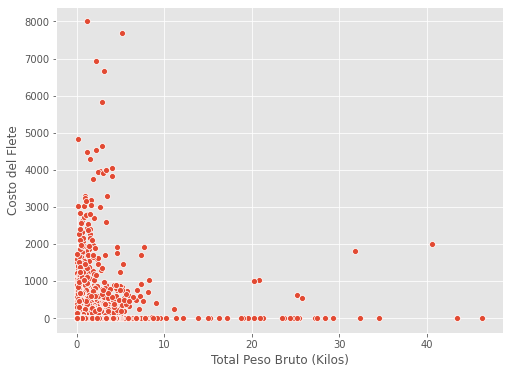

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data["PBK"], y=data["FLETES"])
plt.xlabel("Total Peso Bruto (Kilos)")
plt.ylabel("Costo del Flete")
plt.show()

2. Entre mayor sea el precio de la mercancía (dólares) mayor será el flete.

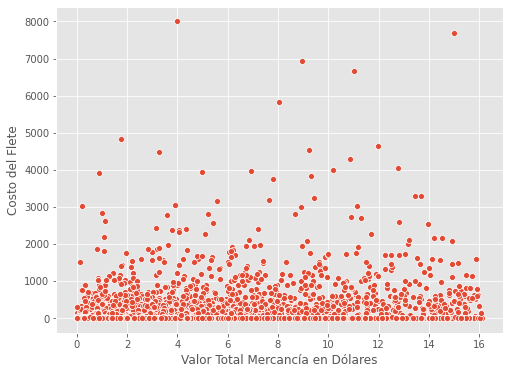

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data.FOBDOL, y=data.FLETES)
plt.xlabel("Valor Total Mercancía en Dólares")
plt.ylabel("Costo del Flete")
plt.show()

3. El 80% de los paises de destino tienen transporte aereo.

<Figure size 576x432 with 0 Axes>

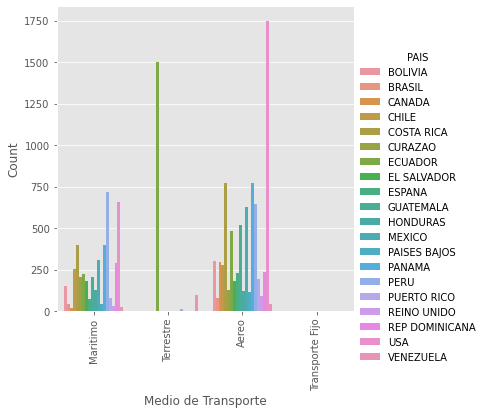

In [49]:
plt.figure(figsize=(8, 6))
ax = sns.catplot("VIA", kind="count", data=data, hue="PAIS")
ax.set_xticklabels(["Maritimo", "Terrestre", 
                    "Aereo", "Transporte Fijo"], rotation=90)
plt.xlabel("Medio de Transporte")
plt.ylabel("Count")
plt.show()

4. El 80% de los códigos de salida tienen medio de transporte terrestre

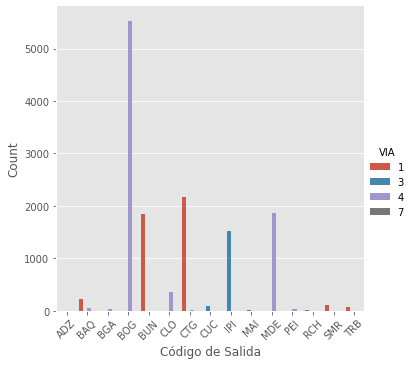

In [58]:
ax = sns.catplot(x="COD_SAL", data=data, kind="count", hue="VIA")
ax.set_xticklabels(rotation=45)
plt.xlabel("Código de Salida")
plt.ylabel("Count")
plt.show()

### **2.2. Análisis de Calidad**

1. Segundo hay que ver las filas duplicadas, estas deberían ser eliminadas puesto que no tiene sentido que hayan dos envíos con las mismas características.
2. Primero hay que hacer un análisis de completitud de datos para saber qué columnas deberían ser eliminadas por alto porcentaje de valores nulos.
3. Como paso último hay que examinar la exactitud y congruencia de los datos, es decir, la lógica de sus valores. 


#### **2.2.1. Duplicados**
- Se van a eliminar las filas duplicadas para evitar sesgos en el análisis

In [71]:
data.duplicated().sum()

191

In [73]:
data = data.drop_duplicates()

#### **2.2.2. Completitud**
- Dado que para nuestro análisis solo son necesarias cuatro columnas, el resto las podremos eliminar.

In [74]:
data_final = data[["FLETES", "PBK", "COD_SAL", "VIA", "PAIS", "FOBDOL"]]

- Dado que los porcentajes de nulidad son muy bajos, no será necesario eliminar ninguna columna de nuestro dataset final. Por otra parte, es mejor si eliminamos las filas con valores nulos para que nuestro análisis no se vea sesgado.

In [75]:
null_percentage(data_final)

{'COD_SAL': '0.0% of null values',
 'FLETES': '0.058245358572988716% of null values',
 'FOBDOL': '0.0% of null values',
 'PAIS': '0.0% of null values',
 'PBK': '0.0% of null values',
 'VIA': '0.0% of null values'}

- Ahora tenemos nuestros datos sin valores nulos

In [76]:
data_final = data_final.dropna()

#### **2.2.3. Exactitud**

In [77]:
for idx, val in zip(data_final.dtypes.index, data_final.dtypes.values):
    if val.name == "category":
        print(f"Valores de {idx}: {data_final[idx].unique()}")

Valores de COD_SAL: [BOG, IPI, BUN, CTG, CLO, ..., PEI, TRB, CUC, MAI, ADZ]
Length: 15
Categories (15, object): [BOG, IPI, BUN, CTG, ..., TRB, CUC, MAI, ADZ]
Valores de PAIS: [PAISES BAJOS, ECUADOR, PANAMA, BRASIL, USA, ..., BOLIVIA, CANADA, VENEZUELA, REINO UNIDO, PUERTO RICO]
Length: 20
Categories (20, object): [PAISES BAJOS, ECUADOR, PANAMA, BRASIL, ..., CANADA, VENEZUELA, REINO UNIDO,
                          PUERTO RICO]


In [78]:
data_final["PBK"].min()

1e-05

In [79]:
data_final["PBK"].max()

46.38

In [80]:
data_final["VIA"].unique()

array([4, 3, 1, 7], dtype=int16)

In [81]:
data_final["FOBDOL"].min()

1e-05

In [82]:
data_final["FOBDOL"].max()

16.12

- Los datos son congruentes puesto que no hay valores negativos ni infinitos donde no debería haber, como el peso o el precio en dólares. Por otra parte las variables categóricas son acordes a los valores esperados.

### **2.3. Ajustes en los datos**
- El primer ajuste que creo pertinente realizar es cambiar los valores numéricos de el medio de transporte por valores de tipo categórico para ser más precisos en el análisis.
- El segundo ajuste es quitar aquellos valores que sean iguales a cero dentro de la variable peso y la variable valor en dólares.

In [83]:
"""
1. Maritimo
3. Terrestre
4. Aereo
7. Transporte Fijo 
"""

via_dict = {
    1: "Maritimo",
    3: "Terrestre",
    4: "Aereo",
    7: "Via Fija"
}

In [86]:
data_final["VIA"] = data_final["VIA"].apply(lambda x: via_dict[x])

In [95]:
data_final = data_final.query("(FOBDOL > 0) & (PBK > 0)")

### **2.4. Pruebas de hipótesis**
1. Entre mayor sea el precio de la mercancía (dólares) mayor será el flete.
- Como podemos darnos cuenta, los coeficientes de pearson, spearman y de kendall muestran un valor muy cercano a cero, lo que puede indicar que las variables "FOBDOL" y "FLETES" son independientes, es decir que el peso del flete no está correlacionado con el valor de la mercancía en dólares. Por lo que esto no genera valor para el negocio

In [96]:
data_final.corr(method="pearson")

FLETES       PBK    FOBDOL
FLETES  1.000000  0.128477  0.239329
PBK     0.128477  1.000000  0.384655
FOBDOL  0.239329  0.384655  1.000000

In [97]:
data_final.corr(method="spearman")

FLETES       PBK    FOBDOL
FLETES  1.000000  0.126713  0.139456
PBK     0.126713  1.000000  0.755339
FOBDOL  0.139456  0.755339  1.000000

In [98]:
data_final.corr(method="kendall")

FLETES       PBK    FOBDOL
FLETES  1.000000  0.098289  0.113758
PBK     0.098289  1.000000  0.558819
FOBDOL  0.113758  0.558819  1.000000

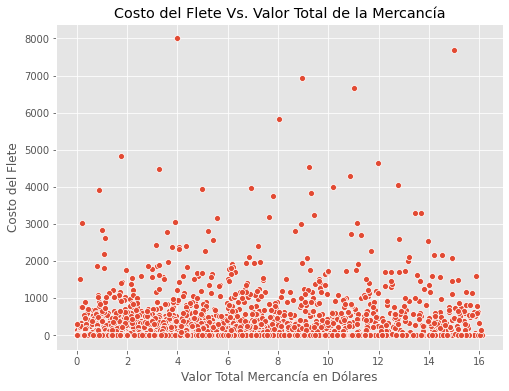

In [110]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_final.FOBDOL, y=data_final.FLETES)
plt.xlabel("Valor Total Mercancía en Dólares")
plt.ylabel("Costo del Flete")
plt.title("Costo del Flete Vs. Valor Total de la Mercancía")
plt.show()

2. El 80% de los códigos de salida tienen medio de transporte terrestre

- Como se ve en la prueba de $\chi ^2$, dado que el p-value dió igual a cero, se puede deducir de esta prueba que las variables "VIA" y "COD_SAL" son dependientes. Es decir que la via de transporte está supeditada del lugar de salida del país.

In [104]:
tabla_salida = pd.crosstab(index=data_final["VIA"], columns=data_final["COD_SAL"])

In [105]:
chi2test(tabla_salida)

Prueba de Chi2 con intervalo de confianza: 0.95
El p-value equivale a: 0.0
Se rechaza la H0


- Gracias a esta gráfica, podemos ver que la gran mayoría de envíos son de índole Aérea.

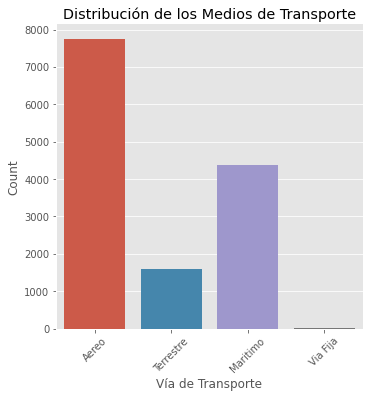

In [117]:
ax = sns.catplot(x="VIA", data=data_final, kind="count")
ax.set_xticklabels(rotation=45)
plt.xlabel("Vía de Transporte")
plt.ylabel("Count")
plt.title("Distribución de los Medios de Transporte")
plt.show()

- Además, desde Bucaramanga es de donde salen más envíos aéreos. Por lo que, si se disminuyera el número de envíos aéreos y se aumentara el número de envíos terrestres, se podrían disminuir los gastos por fletes y se daría más valor al negocio.

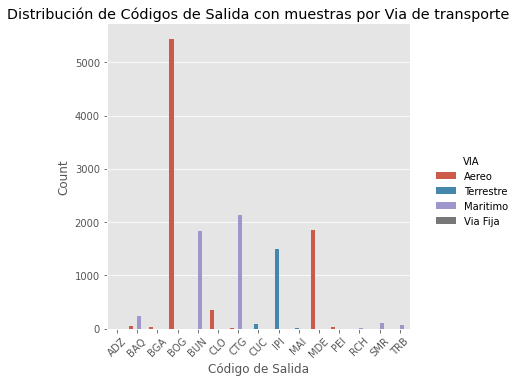

In [109]:
ax = sns.catplot(x="COD_SAL", data=data_final, kind="count", hue="VIA")
ax.set_xticklabels(rotation=45)
plt.xlabel("Código de Salida")
plt.ylabel("Count")
plt.title("Distribución de Códigos de Salida con muestras por Via de transporte")
plt.show()

## **3. Impacto en la ley de protección de datos**
- Dado que el dataset anterior es público, no hay ningún problema en utilizarlo para hacer análisis, sin embargo, es necesario que no se utilice para finces incorrectos. Por otra parte, en lugar de utilizar el ID que viene por defecto, sería bueno crear uno propio con el objetivo de anonimizar cualquier información sensible.